# RSA-UID-switchbaord

Investigating (possibly) meaningful disfluencies in switchboard

### Objectives
1. analysis: do disfluencies appear before high-surprisal items?
2. listener exp: are listeners inclined to choose high-surprisal items as good candidates when they see 'uh'

### Resources
* Switchboard http://www.nltk.org/_modules/nltk/corpus/reader/switchboard.html
* typing animation https://codepen.io/rusjames/pen/uAFhE

In [1]:
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
from nltk.corpus import switchboard as sb
import numpy as np
import pandas as pd
import pdb
import random
import re
import seaborn as sns
import sys
import time

%matplotlib inline  

Example discourse...

In [2]:
discourses = [d for d in sb.discourses()]

In [3]:
discourses[0][:5]

[<A.1: 'Uh , do you have a pet Randy ?'>,
 <B.2: 'Uh , yeah , currently we have a poodle .'>,
 <A.3: 'A poodle , miniature or , uh , full size ?'>,
 <B.4: "Yeah , uh , it 's , uh miniature .">,
 <A.5: 'Uh-huh .'>]

### Preprocessing helpers

In [4]:
def replace_start(s):
    start_patt = r"^<[AB]\.[0-9]{1,}:\s[\'\"]"
    replace_patt = ''
    s = re.sub(start_patt, replace_patt, s)
    return s

def replace_end(s):
    end_patt = r"\s?\'?>"
    replace_patt = ''
    s = re.sub(end_patt, replace_patt, s)
    return s

def remove_punct(s):
    s = re.sub('[,\.\?:\{\}\[\]]', '', s)
    return s

def turn2Str(t):
    unicodeStr = t.unicode_repr()
    s = preprocess_turn_str(unicodeStr)
    return s

def preprocess_turn_str(s):
    s = replace_start(s)
    s = replace_end(s)
    s = remove_punct(s)
    s = s.lower()
    s = re.sub('\s{2,}', ' ', s)
    s = re.sub(r'"$', '', s)
    s = s.rstrip()
    return s

check...

In [5]:
exTurn = discourses[0][2]
print(str(exTurn))
turn2Str(exTurn)

<A.3: 'A poodle , miniature or , uh , full size ?'>


'a poodle miniature or uh full size'

## Data

In [6]:
def removeDisfluencies(s):
    uh_patt = r'\suh\s'
    um_patt = r'\sum\s'
    edited_s = re.sub(uh_patt, ' ', s)
    edited_s = re.sub(um_patt, ' ', edited_s)
    return edited_s
# removeDisfluencies('a poodle miniature or uh full um size')

In [7]:
allStrs = [turn2Str(t) for d in discourses for t in d]
allStrsStartEnd = ['^ ' + s + ' $' for s in allStrs]
allStrsNoDisfluencies = [removeDisfluencies(s) for s in allStrsStartEnd]
orderedTokensAll = ' '.join(allStrsStartEnd).split(' ')
orderedTokensNoDisfluencies = ' '.join(allStrsNoDisfluencies).split(' ')

### LM

In [8]:
class Ngram:
    def __init__(self, n=2):
        self.n = n
        self.vocab_size = 0
        
    def ingest(self, orderedTokens):
        self.vocab_size = len(orderedTokens)
        d = defaultdict(Counter)
        for i, word in enumerate(orderedTokens):
            if i == len(orderedTokens)-self.n:
                break
            currTup = tuple(orderedTokens[i:i+self.n-1])
            d[currTup][orderedTokens[i+self.n-1]] += 1
        self.lm = d
        
    def get_lm(self):
        return self.lm
    
    def get_candidates(self, token):
        return self.lm[token]
    
    def get_cond_prob(self, tup):
        context = tup[0:self.n-1]
        target = tup[self.n-1]
        num = self.lm[context][target]
        denom = np.sum([d[1] for d in self.lm[context].items()])
        return num / denom if denom != 0 else 0.0
    
    def get_cond_count(self, tup):
        context = tup[0:self.n-1]
        target = tup[self.n-1]
        num = self.lm[context][target]
        return num      
        

check...

In [9]:
ng2 = Ngram(n=2)
ng3 = Ngram(n=3)
exCorpus = ['apple', 'on', 'the', 'apple', 'on', 'a', 'range', 'apple']
ng2.ingest(exCorpus)
ng3.ingest(exCorpus)
ng2.get_cond_count(('on', 'apple'))
ng3.get_cond_count(('on', 'the', 'apple'))

1

## Reproducing Levy & Jaeger (2007) that-omission analysis (section 4)

**Objective**:
What is the relationship between `uh/um` presence and the informativity of the following text?
* H_0: there is no relationship
* H_1: presence of `uh/um` indicates the following content is high-surprisal.

In [10]:
ng_all = Ngram(n=3)
ng_all.ingest(orderedTokensAll)
ng_no_disfluencies = Ngram(n=2)
ng_no_disfluencies.ingest(orderedTokensNoDisfluencies)

In [11]:
disfluentStrs = [s for s in allStrsStartEnd if 'uh' in s.split() or 'um' in s.split()]
disfluentStrs[100]

'^ and we do a lot of um stir fry vegetables $'

In [12]:
def getKtuple(s, k=2):
    s_split = s.split(' ')
    d = []
    for i, token in enumerate(s_split):
        if i == len(s_split)-k:
            break
        curr_tup = tuple(s_split[i:i+k])
        d.append(curr_tup)
    return d
# getKtuple(uhStrs[0])

In [13]:
def getSentProbs(s, model, n):
    d = {}
    for tup in getKtuple(s, n):
        d[tup] = model.get_lm_prob(tup)
    return d
# getSentProbs(removeUhs(uhStrs[0]), ng_no_uh, n)

### Todo

* Get all instances of find all context / targets (w/ and w/o disfluencies and get surprisal)

In [15]:
d = []
for s in disfluentStrs:
    three_tuples = getKtuple(s, 3)
    for i, k in enumerate(three_tuples):
        if (k[1] == 'uh' or k[1] == 'um') and (sum([i == 'uh' or i == 'um' for i in k]) == 1):
            disfluency = k[1]
            before = k[0]
            after = k[2]
            t = (before, after)
            non_disfluent_cnt = ng_no_disfluencies.get_cond_count(t)
            disfluent_cnt = ng_all.get_cond_count(k)
            if disfluent_cnt > non_disfluent_cnt:
                pdb.set_trace()
            lik = disfluent_cnt / non_disfluent_cnt
            surp = np.log2(ng_no_disfluencies.get_cond_prob(t))
            data = {
                'before': before,
                'after': after,
                'lik': lik,
                'supr': surp,
                'total':non_disfluent_cnt,
                'disfluency': disfluency
            }
            d.append(data)

In [16]:
df = pd.DataFrame(d).drop_duplicates()
# df.to_csv('switchboard-uh-data-20171215.csv')

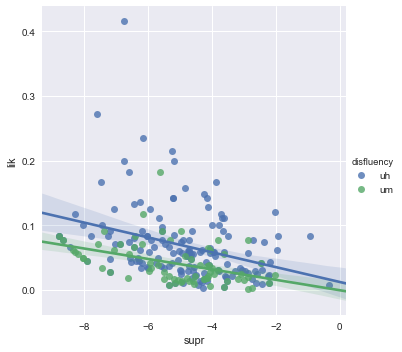

In [17]:
sns.lmplot(x='supr', y='lik', hue='disfluency', data=df[df['total']>10])

## Experiment - brainstorm

* Task: sentence completion - particiants see a sentence fragment and have to fill in the missing item from a choice of five candidates. 
    + include the "true" candidate?
    + include a spectrum of high->low suprisal items
* What if we had people incrementally build sentences from the LM candidates?
    

In [18]:
ng = Ngram(2)
ng.ingest(orderedTokensAll)

In [19]:
# sent = random.choice(allStrs).split(' ')
# index = random.randint(0, len(sent))
# sent[:index]
exSent = 'yeah i have a uh well a mutt myself i call it a uh uh chowperd'
exSentSplit = exSent.split(' ')
index = random.randint(1, len(exSentSplit)-1)
fragment = exSentSplit[:index]

In [20]:
lastToken = fragment[-1]
print(lastToken)
trueCandidate = exSentSplit[index]

mutt


In [21]:
lm_candidates = list(ng.get_candidates((lastToken,)).keys())
candidates = set(random.sample(lm_candidates, min(5, len(lm_candidates)))) | {trueCandidate}

In [22]:
print("Full utterace:\t{}".format(exSent))
print('Fragment:\t{}'.format(' '.join(fragment)))
print('Last token:\t{}'.format(lastToken))
print('Candidates:\t{}'.format(candidates))
print('True candidate:\t{}'.format(trueCandidate))

Full utterace:	yeah i have a uh well a mutt myself i call it a uh uh chowperd
Fragment:	yeah i have a uh well a mutt
Last token:	mutt
Candidates:	{'myself'}
True candidate:	myself


## Experiment - just "uh's"

Exploring "Um implicature" -- do participants display a high-surprisal bias in sentence completion task.

Avoid:
* sentence initial disfluencies


In [23]:
uhStrs = [s for s in allStrsStartEnd if 'uh' in s.split()]
uhStrs_sample = random.sample(uhStrs, 10)
uhStrs_sample[0]

"^ you bet well that that 's what ended up being the real problem on this was the uh i- the the pipe was n't busted but the it was n't soldered in good enough $"

In [24]:
def get_match_indices(x, s):
    return [i for i, w in enumerate(s.split(' ')) if w == x]

In [25]:
indices = get_match_indices('uh', uhStrs_sample[0])
index = indices[0]

In [26]:
' '.join(uhStrs_sample[0].split(' ')[0:index+1])

"^ you bet well that that 's what ended up being the real problem on this was the uh"

In [27]:
class categoricalDistr:
    def __init__(self, vs, ps):
        self.vs = vs
        self.ps = ps
        self.normed_ps = self.normalize(self.ps)
        self.distr = dict(zip(self.vs, self.normed_ps))
        
    def sample(self, k=5):
        vals = np.random.choice(a=self.vs, size=(k), p=self.normed_ps)
        d = {}
        for v in vals:
            d[v] = self.distr[v]
        return d
    
    def get_prob(self, x):
        return self.distr[x]

    def normalize(self, x):
        return x / np.sum(x)

In [28]:
vs = list(ng.get_candidates(('uh',)).keys())
ps = list(ng.get_candidates(('uh',)).values())
C = categoricalDistr(vs, ps)

In [29]:
C.sample()

{'she': 0.015019762845849802,
 'the': 0.043478260869565216,
 'thought': 0.0015810276679841897,
 'we': 0.017391304347826087,
 'yes': 0.0031620553359683794}

In [30]:
C.get_prob('i')

0.11304347826086956

In [33]:
def runExperiment(data, n_trials=10, n_candidates=3):
    """
    Parameters
    ----------
    data: array of str
        Sentences / sentence fragments.    
    n_iters: int
        Number of trials.
    n_candidates: int
        Size of comparison set.
        
    Returns
    list of dicts
        Results.
        
    """
    d = []
    random.shuffle(data)
    for i, sent in enumerate(data):
        if i >= n_trials:
            break
        sent_split = sent.split(' ')
        index = random.randint(1, len(sent_split)-1)
        target = sent_split[index]
        true_candidate = sent_split[index+1]
        fragment = sent_split[:index]
        fragment_str = ' '.join(fragment)
        vs = list(ng.get_candidates((target,)).keys())
        ps = list(ng.get_candidates((target,)).values())
        C = categoricalDistr(vs, ps)
        candidates = C.sample(n_candidates)
        candidates[true_candidate] = C.get_prob(true_candidate)
        if len(candidates) < n_candidates or len(fragment) < 3:
            continue
        candidate_keys = list(candidates.keys())
        candidate_vals = list(candidates.values())
        print('------')
        print("Evaluate:\n")
        for ch in fragment_str:
            print(ch, end='')
            time.sleep(0.1)
        print("\nPlease choose one:\t{}".format(candidate_keys))
        user_choice = input("Choice (1, 2, 3, 4):")
        data = {}
        for i, (k, v) in enumerate(candidates.items()):
            data['candidate' + str(i) + '_key'] = k
            data['candidate' + str(i) + '_val'] = v
        data['frag'] = fragment_str
        data['true_candidate_key'] = true_candidate
        data['true_candidate_val'] = candidates[true_candidate]
        data['choice'] = user_choice
        d.append(data)
    return d
    
d = runExperiment(uhStrs, 3)

------
Evaluate:

^ you know in the the whole state of maryland i believe there 's only like
Please choose one:	['i', 'youngsters', 'just', 'fifteen']
Choice (1, 2, 3, 4):fifteen
------
Evaluate:

^ a poodle miniature or uh
Please choose one:	['of', 'time', 'size']
Choice (1, 2, 3, 4):size
------
Evaluate:

^ and i 'm thinking that community service would help them uh just get a feel of what else is out there how other people are living you know if they were to
Please choose one:	['but', 'till', 'that', 'in']
Choice (1, 2, 3, 4):in


In [34]:
df = pd.DataFrame(d)

In [35]:
df['correct'] = df['choice'] == df['true_candidate_key']

In [36]:
sum(df['correct'])

3

In [37]:
df.head()

,candidate0_key,candidate0_val,candidate1_key,candidate1_val,candidate2_key,candidate2_val,candidate3_key,candidate3_val,choice,frag,true_candidate_key,true_candidate_val,correct
0,i,0.113043,youngsters,0.000791,just,0.008696,fifteen,0.000791,fifteen,^ you know in the the whole state of maryland ...,fifteen,0.000791,True
1,of,0.333333,time,0.444444,size,0.111111,NaN,NaN,size,^ a poodle miniature or uh,size,0.111111,True
2,but,0.023529,till,0.011765,that,0.011765,in,0.070588,in,^ and i 'm thinking that community service wou...,in,0.070588,True
